## Classificação de imagens utilizando multiplos modelos de classificação


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [2]:
import sys
sys.path.append('../')
from utils import plot_2d_embedding

# MNIST Problem


The MNIST database of handwritten digits, [available from this page](http://yann.lecun.com/exdb/mnist/), has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. 

In [3]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()

In [4]:
#shape de treino dos datasets

print(x_train_mnist.shape)
print(y_train_mnist.shape)
print(x_test_mnist.shape)
print(y_test_mnist.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [5]:
# investigando quantos valores existem em cada classe
pd.DataFrame(y_train_mnist, columns = ['classes']).groupby('classes').size()

classes
0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
dtype: int64

In [6]:
x_train_mnist[0].shape

(28, 28)

### Entendendo uma imagem: Uma Matriz! (ou tensor)

In [7]:
x_train_mnist[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

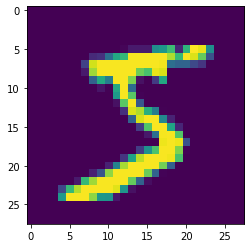

In [8]:
plt.imshow(x_train_mnist[0])

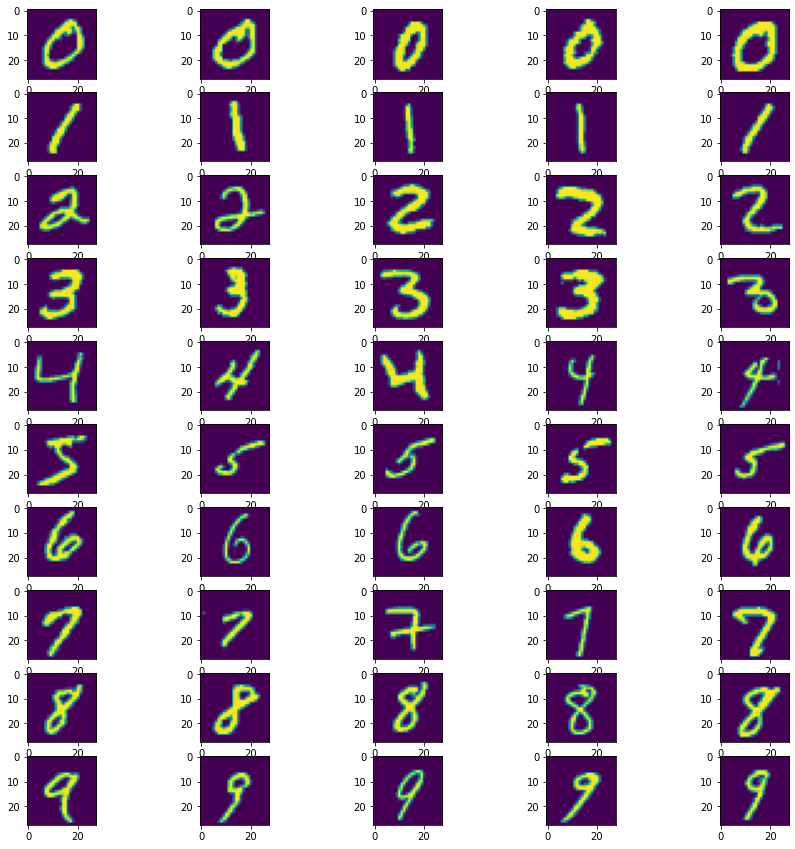

In [9]:
num_labels = 10
num_columns = 5

fig, ax = plt.subplots(num_labels, num_columns, figsize=(15,15))


for label in range(num_labels):
    for i in range(num_columns):
        images = x_train_mnist[y_train_mnist == label][0:num_columns]
        ax[label,i].imshow(images[i])

### Vetorização das matrizes (Flatten)

![flatten](../imgs/flatten.png)

## Exemplo 

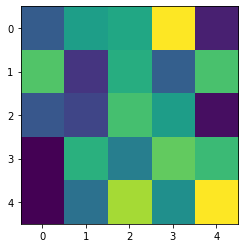

In [10]:
example = np.random.rand(5,5)
plt.imshow(example)

In [11]:
print(example)
example.shape

[[0.31121247 0.55889163 0.59243115 0.96409847 0.12366   ]
 [0.71351382 0.18664774 0.61577221 0.32027069 0.69790292]
 [0.29373942 0.23489414 0.6910563  0.55608509 0.07620183]
 [0.04277582 0.62634895 0.43830739 0.74443174 0.66973698]
 [0.04600334 0.38555127 0.84152853 0.50222069 0.9638912 ]]


(5, 5)

In [12]:
flat = example.flatten()
print(flat)
flat.shape

[0.31121247 0.55889163 0.59243115 0.96409847 0.12366    0.71351382
 0.18664774 0.61577221 0.32027069 0.69790292 0.29373942 0.23489414
 0.6910563  0.55608509 0.07620183 0.04277582 0.62634895 0.43830739
 0.74443174 0.66973698 0.04600334 0.38555127 0.84152853 0.50222069
 0.9638912 ]


(25,)

In [13]:
reshape = example.reshape(-1,1)
print(reshape)
reshape.shape

[[0.31121247]
 [0.55889163]
 [0.59243115]
 [0.96409847]
 [0.12366   ]
 [0.71351382]
 [0.18664774]
 [0.61577221]
 [0.32027069]
 [0.69790292]
 [0.29373942]
 [0.23489414]
 [0.6910563 ]
 [0.55608509]
 [0.07620183]
 [0.04277582]
 [0.62634895]
 [0.43830739]
 [0.74443174]
 [0.66973698]
 [0.04600334]
 [0.38555127]
 [0.84152853]
 [0.50222069]
 [0.9638912 ]]


(25, 1)

### reshape de todas as imagens 

In [14]:
reshaped_train = x_train_mnist.reshape(60000, 28*28)
reshaped_test = x_test_mnist.reshape(10000, 28*28)

Agora, cada linha é uma imagem vetorizada. Podemos conferir, recuperando uma imagem como exemplo.

In [15]:
reshaped_train[0].reshape(28,28)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

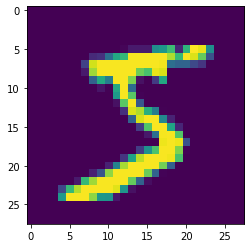

In [16]:
plt.imshow(reshaped_train[0].reshape(28,28))

### Exploração da Matriz a ser modelada

Calculando correlação entre os pixels das imagens

In [17]:
df = pd.DataFrame(reshaped_train)
corr = df.corr()

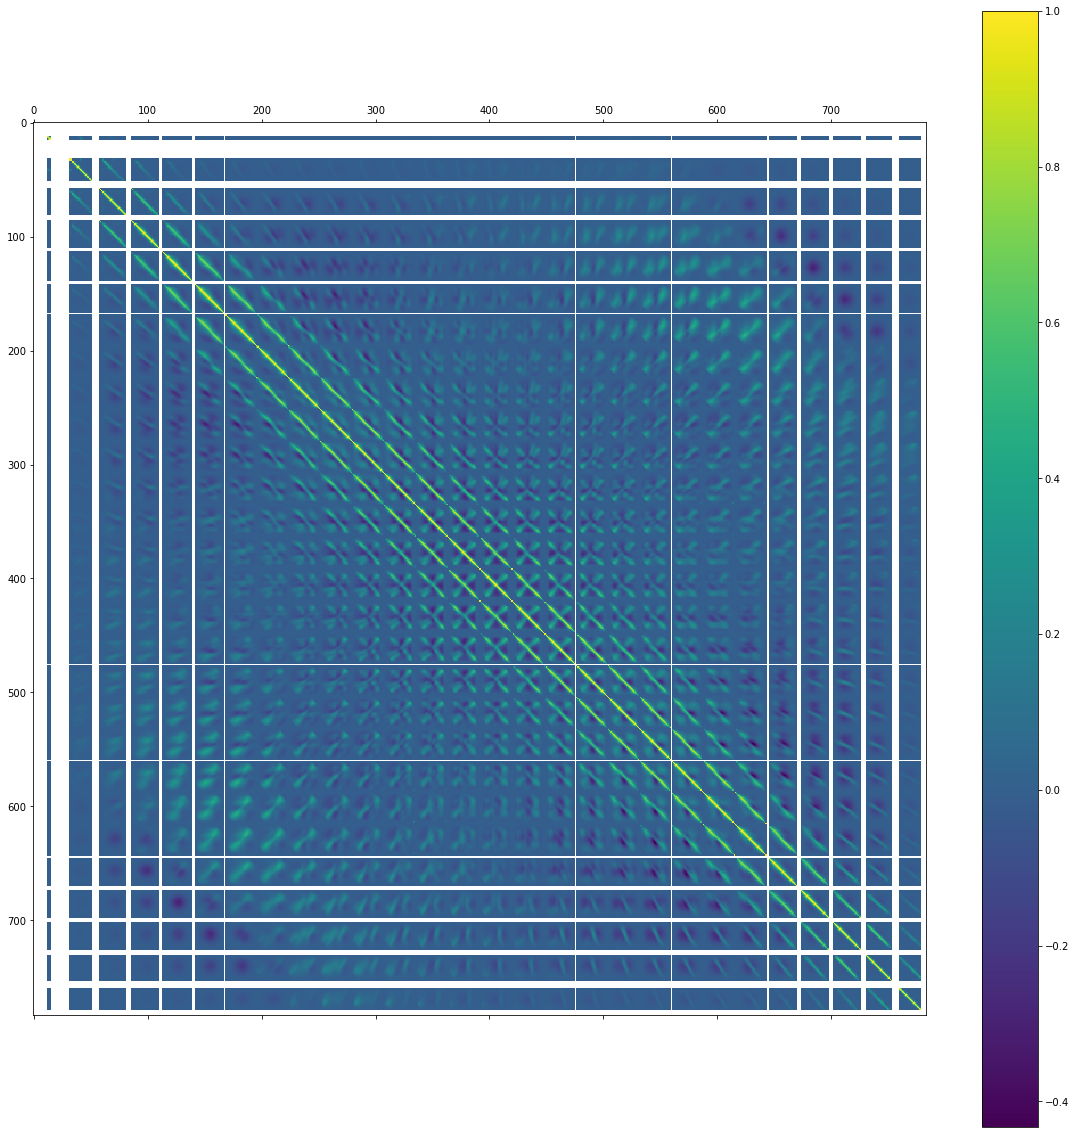

In [17]:
plt.figure(figsize=(20, 20))
plt.matshow(corr, fignum = 1)
plt.colorbar()

Importante notar: Existem colunas que são correlacionadas e também existem colunas inteiras que são constantes. Isso significa que essas colunas não agregam nenhum valor para nenhum modelo, dado que eles não variam em função dos obvserváveis.

In [18]:
# removendo columns constantes.
# df.iloc[0] -> primeiro valor de cada coluna
# df != do primeiro valor de cada coluna? por coluna
# .any() -> algum deles é diferente do primeiro valor de cada coluna?
bool_indicator = (df != df.iloc[0]).any()
df_without_constant_columns = df.loc[:, bool_indicator]

In [19]:
corr = df_without_constant_columns.corr()

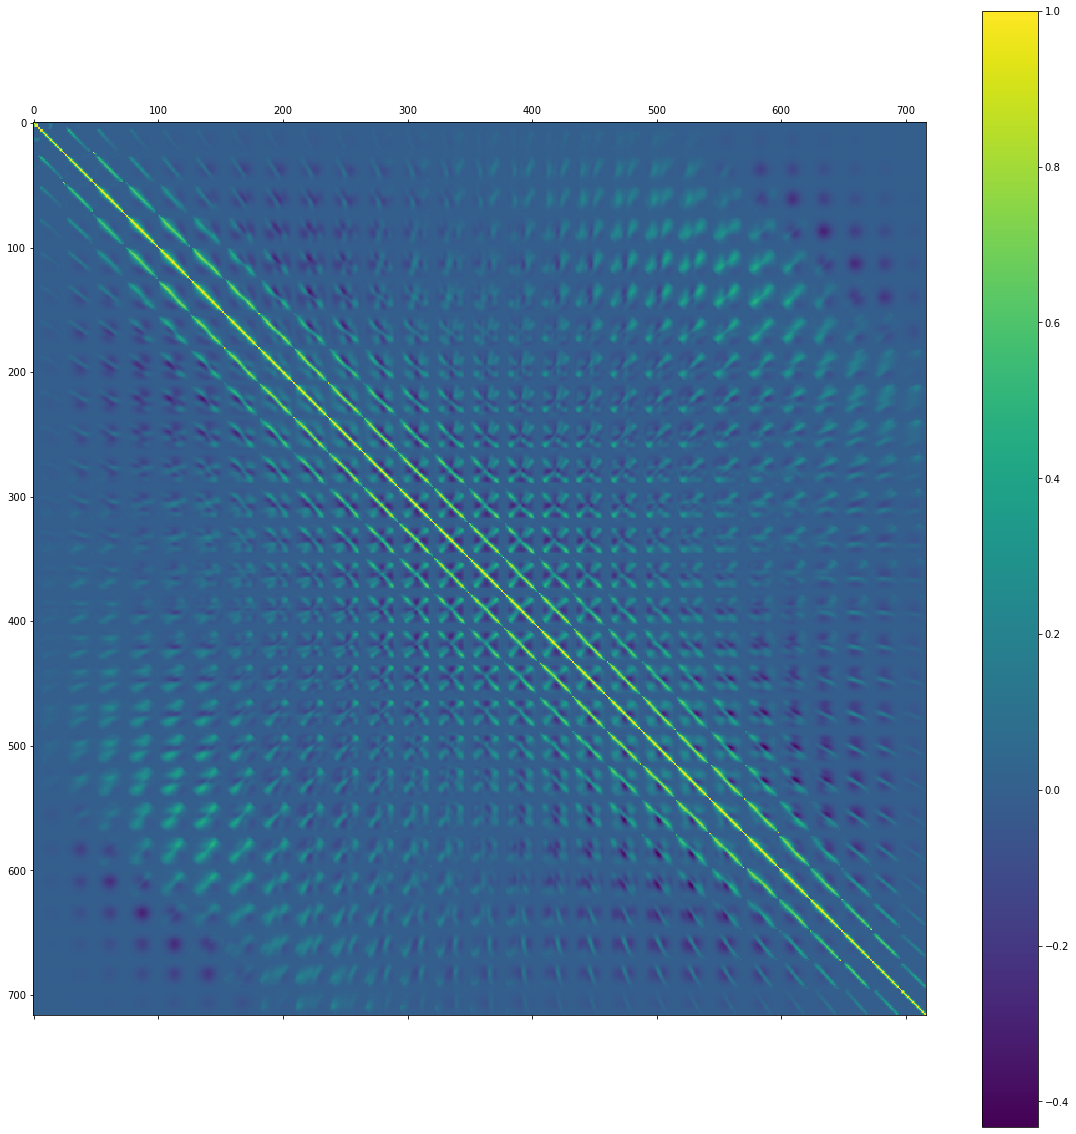

In [20]:
plt.figure(figsize=(20, 20))
plt.matshow(corr, fignum = 1)
plt.colorbar()

## PCA

In [19]:
pca = PCA()
pca.n_components = df_without_constant_columns.shape[1]
pca_data = pca.fit_transform(df_without_constant_columns)

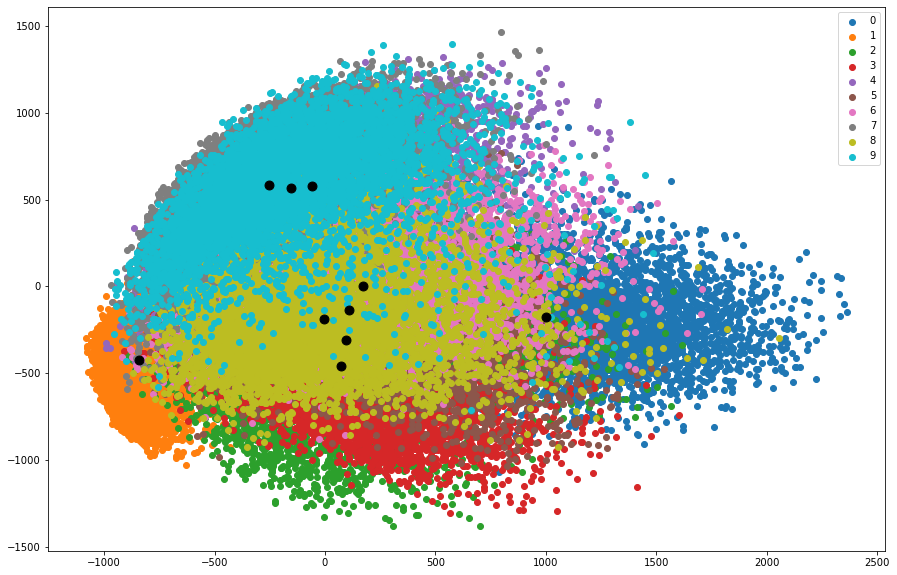

In [20]:
x = pca_data[:,0]
y = pca_data[:,1]

label = y_train_mnist
u_labels = np.unique(y_train_mnist)

plt.figure(figsize=(15, 10))

centroids_0 = []
centroids_1 = []

for i in u_labels:
    x_current = x[label == i]
    y_current = y[label == i]
    
    centroids_0.append(x_current.mean())
    centroids_1.append(y_current.mean())
    
    plt.scatter(x_current, y_current, label = i)
plt.scatter(centroids_0 , centroids_1 , s = 80, color = 'k')
plt.legend()
plt.show()

percebemos que existem segmentos, mas eles se sobresaem em duas dimensões: Não conseguimos explicar muito bem o comportamento do dado apenas com essas informações.

In [21]:
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

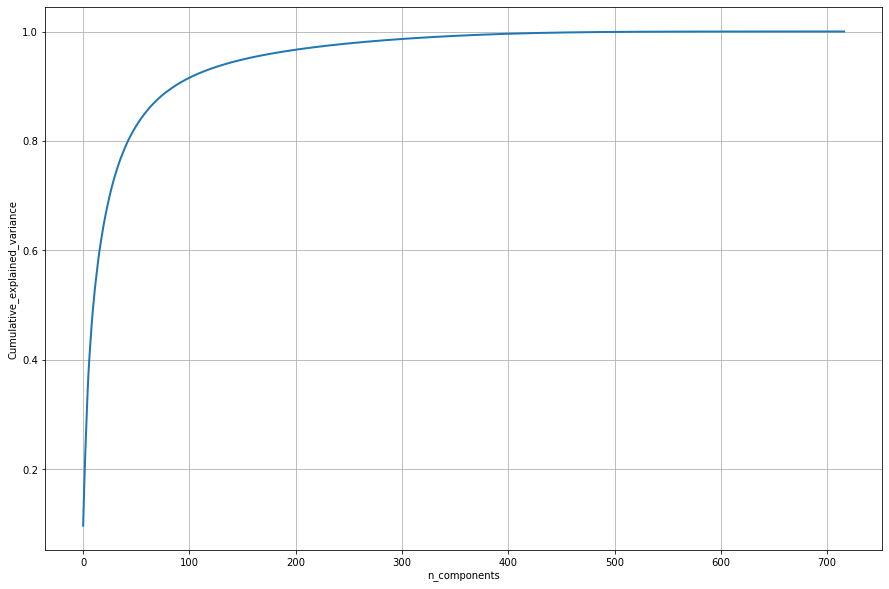

In [22]:
plt.figure(figsize=(15, 10))
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

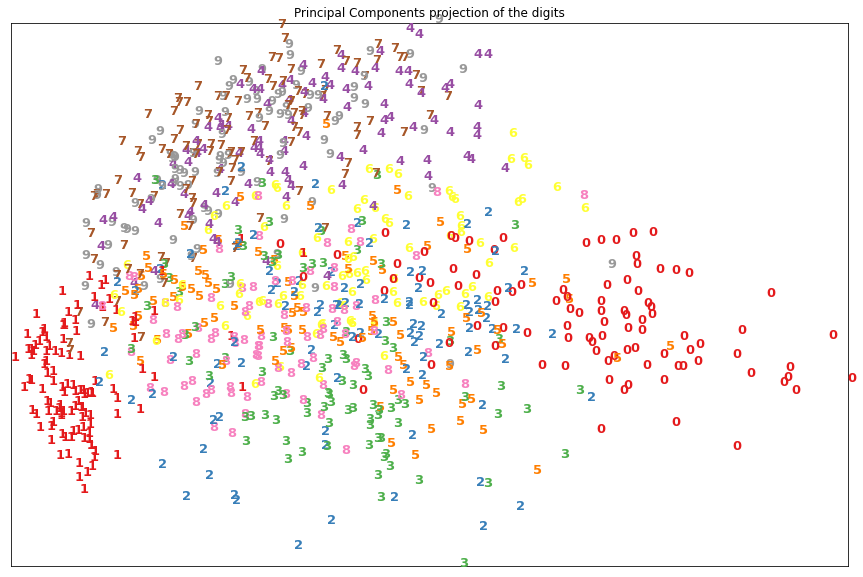

In [23]:
y = y_train_mnist[0:1000]
plot_2d_embedding(pca_data[0:1000], y,
               "Principal Components projection of the digits", size = 13)

Com mais dimensões, temos mais da variabilidade explicada. Assim, conseguimos trazer aproximadamente 90% da variabilidade do dado para o modelo com 100 componentes.

## LDA 

In [27]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(df_without_constant_columns, y_train_mnist)
lda_data = lda.transform(df_without_constant_columns)

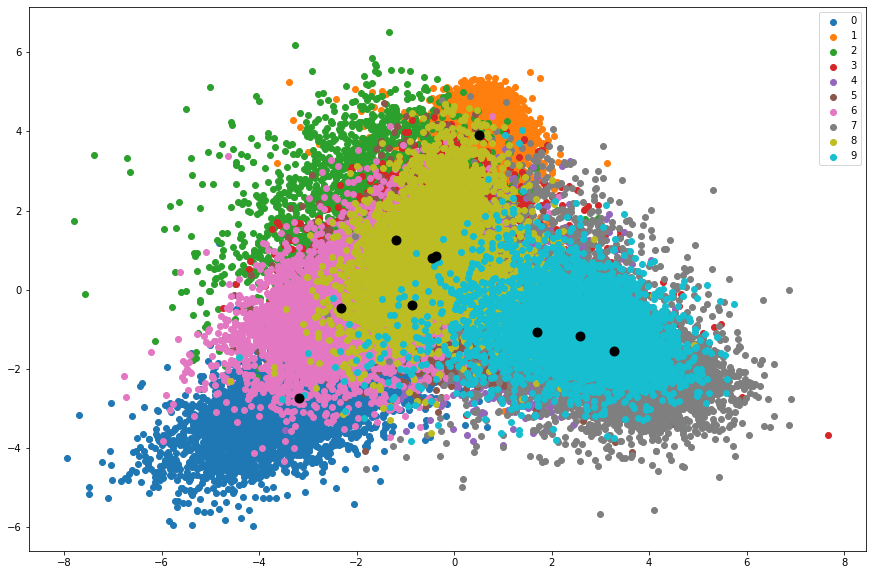

In [28]:
x = lda_data[:,0]
y = lda_data[:,1]

label = y_train_mnist
u_labels = np.unique(y_train_mnist)

plt.figure(figsize=(15, 10))

centroids_0 = []
centroids_1 = []

for i in u_labels:
    x_current = x[label == i]
    y_current = y[label == i]
    
    centroids_0.append(x_current.mean())
    centroids_1.append(y_current.mean())
    
    plt.scatter(x_current, y_current, label = i)
plt.scatter(centroids_0 , centroids_1 , s = 80, color = 'k')
plt.legend()
plt.show()

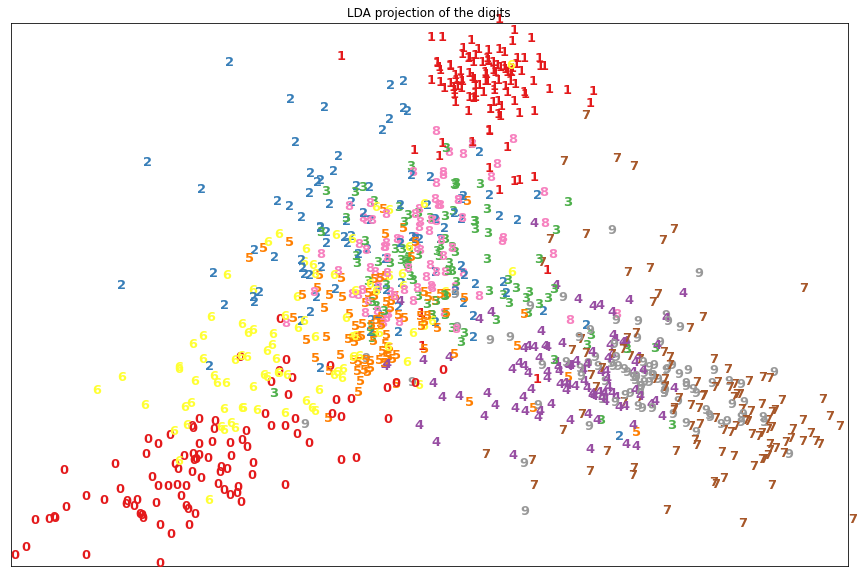

In [29]:
y = y_train_mnist[0:1000]
plot_2d_embedding(lda_data[0:1000], y,
               "LDA projection of the digits", size = 13)

## T-SNE

In [30]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(df_without_constant_columns[0:1000])

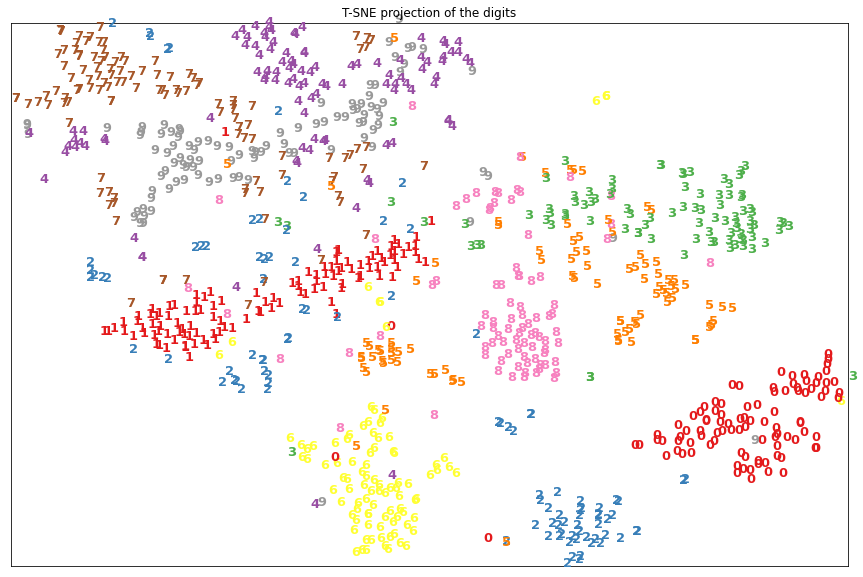

In [31]:
y = y_train_mnist[0:1000]
plot_2d_embedding(X_embedded, y,
               "T-SNE projection of the digits", size = 13)

# Modelagem 

Vamos realizar o processamento do dado para o shape que gostaríamos, também remover as colunas que não trazem informação. Além disso, realizaremos o PCA, para reduzirmos a dimensão do problema.

In [43]:
reshaped_train = reshaped_train[:, bool_indicator]
reshaped_test = reshaped_test[:, bool_indicator]

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Search para melhor numero de componentes e de penalizacao para regressao logisticia

pca = PCA()

# tol = tolerancia para não demorar muito rodando (atencao para convergencia)
# multi_class = "multinomial" por ser um dataset com mais de 2 labels.
# Note que por default, a classe já identifica e trata isso, mas preferi explicitar.
# Nesse caso, o modelo utiliza a distribuição multinomial ao invés da bernoulli na modelagem

logistic = LogisticRegression(max_iter=10000, tol=0.1, multi_class="multinomial")

pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# parametros de diferentes steps da pipeline podem ser definidos com '__'
param_grid = {
    'pca__n_components': [2, 100],
    'logistic__C': np.logspace(-4, 4, 2),
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(reshaped_train, y_train_mnist)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Best parameter (CV score=0.917):
{'logistic__C': 0.0001, 'pca__n_components': 100}


In [59]:
search.cv_results_

{'mean_fit_time': array([ 32.60337095, 216.54022059,  52.29586411, 212.30681181]),
 'std_fit_time': array([ 5.00977017, 91.6133297 , 11.60372028, 57.08165968]),
 'mean_score_time': array([0.15989609, 0.21299176, 0.2033833 , 0.1687922 ]),
 'std_score_time': array([0.01644921, 0.03054635, 0.05291542, 0.03408367]),
 'param_logistic__C': masked_array(data=[0.0001, 0.0001, 10000.0, 10000.0],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_pca__n_components': masked_array(data=[5, 100, 5, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'logistic__C': 0.0001, 'pca__n_components': 5},
  {'logistic__C': 0.0001, 'pca__n_components': 100},
  {'logistic__C': 10000.0, 'pca__n_components': 5},
  {'logistic__C': 10000.0, 'pca__n_components': 100}],
 'split0_test_score': array([0.673     , 0.92016667, 0.674     , 0.91941667]),
 'split1_test_score': array([0.66791667, 0.9

In [55]:
from sklearn.metrics import classification_report

y_pred = search.predict(reshaped_test)
target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(y_test_mnist, y_pred, target_names=target_names))
search.predict(reshaped_test) 

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.90      0.90      1010
           4       0.92      0.93      0.92       982
           5       0.89      0.86      0.87       892
           6       0.94      0.95      0.94       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.90      0.90      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

# Fashion problem

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. The github project is [available here](https://github.com/zalandoresearch/fashion-mnist).

In [ ]:
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
print(x_train_fashion.shape)
print(y_train_fashion.shape)

In [21]:
x_train_fashion[0].shape

(28, 28)

In [22]:
x_train_fashion[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

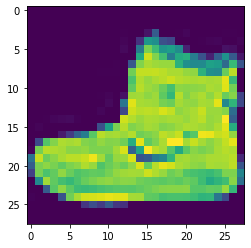

In [23]:
plt.imshow(x_train_fashion[0])

In [25]:
# investigando quantos valores existem em cada classe
pd.DataFrame(y_train_fashion, columns = ['classes']).groupby('classes').size()

classes
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
dtype: int64

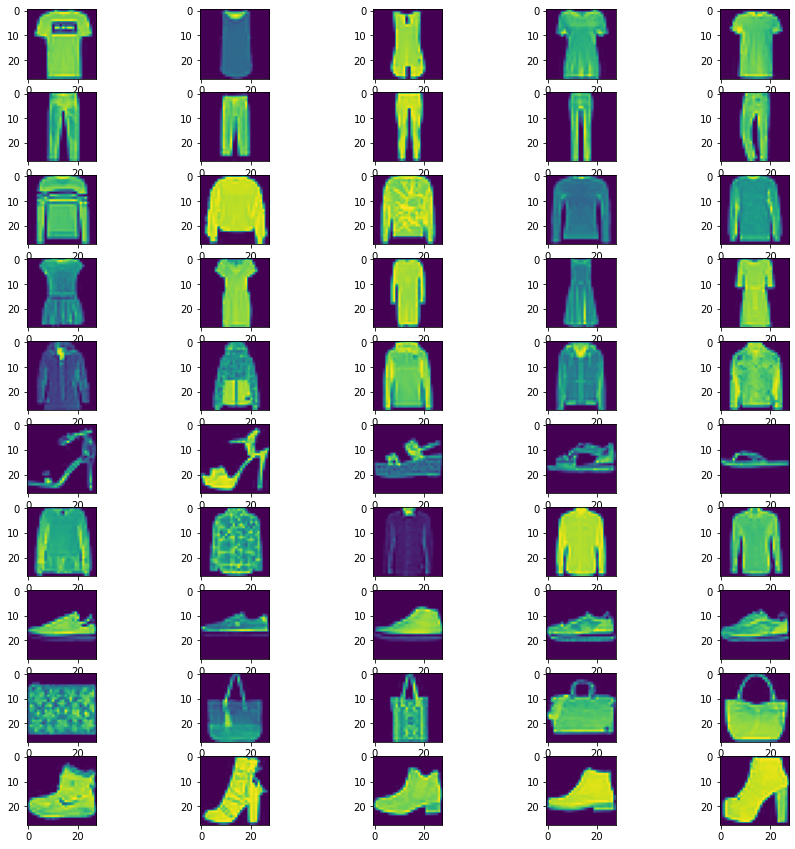

In [26]:
num_labels = 10
num_columns = 5

fig, ax = plt.subplots(num_labels, num_columns, figsize=(15,15))


for label in range(num_labels):
    for i in range(num_columns):
        images = x_train_fashion[y_train_fashion == label][0:num_columns]
        ax[label,i].imshow(images[i])